In [1]:
from dask.distributed import LocalCluster, Client
from dotenv import load_dotenv
import pvdeg
import os

### Setting Up

As in [load_pvgis_distributed.ipynb](./load_pvgis_distributed.ipynb) we need to get ready to make our parallelized API calls. The notebook linked here goes through the process in more detail but we need to import our API key and email. This cell will not work for you unless you replace the `api_key` and `email` with your personal NSRDB api keys. [REQUEST A KEY](https://developer.nrel.gov/signup/).

We also need to initalize a dask client. `pvdeg.weather.weather_distributed` will not work without it. It will fail silently and not populate and of the results in the resulting `weather_ds` called `geo_weather` in the example below. It is hard to recognize that this has occured so be careful. Make sure to initialize a dask client first. Visiting the link takes you to a daskboard that shows what dask is doing.

In [2]:
load_dotenv()

### REPLACE WITH YOUR API KEY AND EMAIL ###
api_key = os.getenv("api_key")
email = os.getenv("email")
###########################################

workers = 4

cluster = LocalCluster(
    n_workers=workers,
    processes=True,
)

client = Client(cluster)

print("Daskboard link")
print(client.dashboard_link)

http://127.0.0.1:8787/status


## Requesting Weather

As with the other script [load_pvgis_distributed.ipynb](./load_pvgis_distributed.ipynb). We will create a list of tuple (latitude, longitude) pairs and call the function on all of them at once. failed will represent a list of failed gids, unique location ID's that correspond to points in space on the NSRDB. These are different than on PVGIS where they are arbitrary indexes that do NOT correspond to a spatial location on earth.

We will request "PSM3" data from the Physical Solar Model that represents a typical meteorological year (TMY) from the NSRDB. We will have to supply the api key and email from above here. Refer to the linked script to see this in further detail. The only difference between the scripts, lies in the NSRDB/PSM3 data requiring Api keys.

In [3]:
coords = [
    (25.783388, -80.189029),
    (24.783388, -80.189029),
]

geo_weather, geo_meta, failed = pvdeg.weather.weather_distributed(
    database="PSM3", coords=coords, api_key=api_key, email=email
)

### Viewing Results

Same as in the other tutorial, our results are stored in an xarray dataset with a dask backend so you will have to use `.compute()` on the dataset to inspect the individual values of the dask arrays. 

Click on the `Data variables` dropdown to expand the dataset viewer.

In [7]:
geo_weather

<xarray.Dataset> Size: 2MB
Dimensions:            (gid: 2, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int32 8B 0 1
Data variables: (12/15)
    Year               (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Month              (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Day                (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Hour               (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    Minute             (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    temp_air           (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    ...                 ...
    ghi                (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    albedo             (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    pressure           (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    wind_direction     (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    wind_speed         (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>
    relative_humidity  (gid, time) float64 140kB dask.array<chunksize=(2, 8760), meta=np.ndarray>

In [9]:
geo_weather.compute()

<xarray.Dataset> Size: 2MB
Dimensions:            (gid: 2, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int32 8B 0 1
Data variables: (12/15)
    Year               (gid, time) float64 140kB 2.005e+03 ... 2.002e+03
    Month              (gid, time) float64 140kB 1.0 1.0 1.0 ... 12.0 12.0 12.0
    Day                (gid, time) float64 140kB 1.0 1.0 1.0 ... 31.0 31.0 31.0
    Hour               (gid, time) float64 140kB 0.0 1.0 2.0 ... 21.0 22.0 23.0
    Minute             (gid, time) float64 140kB 30.0 30.0 30.0 ... 30.0 30.0
    temp_air           (gid, time) float64 140kB 22.0 21.0 21.0 ... 22.0 22.0
    ...                 ...
    ghi                (gid, time) float64 140kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    albedo             (gid, time) float64 140kB 0.1 0.1 0.1 ... 0.01 0.01 0.01
    pressure           (gid, time) float64 140kB 1.02e+03 1.02e+03 ... 1.01e+03
    wind_direction     (gid, time) float64 140kB 94.0 93.0 92.0 ... 103.0 108.0
    wind_speed         (gid, time) float64 140kB 6.4 6.1 5.9 5.6 ... 7.9 7.9 7.8
    relative_humidity  (gid, time) float64 140kB 73.29 77.92 ... 73.29 73.29

### Spot Check

We can plot the entire TMY air_temperature to check that our data has loaded correctly. 

Explanation of steps

geo_weather is our weather xarray dataset. We can index into the first entry at the 0th index by using isel (index-select). This will grab the data from the first gid. Then we pick the air temperature attribute. This can be replaced with bracket notation so `.temp_air` becomes `["temp_air"]. 

This selects a single array from the dataset that is labeled as "temp_air". This array will be a dask array so the values will be stored out of memory, we would have to load it using `.compute()` to directly inspect it but when plotting with matplotlib it will load the array for us.

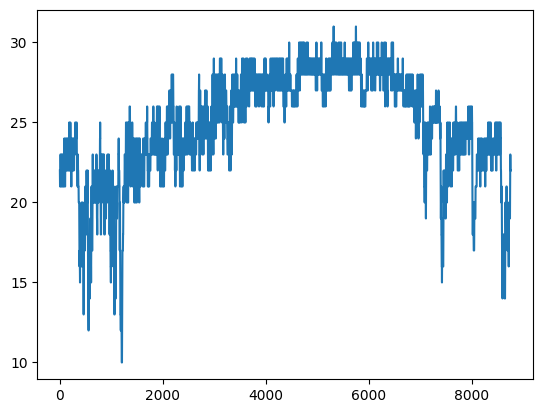

In [10]:
import matplotlib.pyplot as plt

plt.plot(geo_weather.isel(gid=0).temp_air)

### Next Steps

Now we have data ready to use for geospatial calculations. This is shown in the other distributed script [load_pvgis_distributed.ipynb](./load_pvgis_distributed.ipynb). You can also see how to do this in [Geospatial Templates.ipynb](../tutorials_and_tools/tutorials_and_tools/Geospatial%20Templates.ipynb)